In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
train_df = pd.read_csv('D:/ResearchIdeas/0.BreastCancer/archive/csv/mass_case_description_train_set.csv')
test_df = pd.read_csv('D:/ResearchIdeas/0.BreastCancer/archive/csv/mass_case_description_test_set.csv')
train_df.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


### 2. Data preparation and data cleaning

In [3]:
train_df = train_df.drop(columns=['patient_id','abnormality type', 'image file path', 'cropped image file path','ROI mask file path'], errors='ignore')
test_df = test_df.drop(columns=['patient_id','abnormality type', 'image file path', 'cropped image file path','ROI mask file path'], errors='ignore')

In [4]:
def apply_category(train_df, test_df):
    # Replace spaces with underscores in column names for both dataframes
    train_df.columns = [col.replace(' ', '_') for col in train_df.columns]
    test_df.columns = [col.replace(' ', '_') for col in test_df.columns]

    # Convert specified columns to 'category' type for both dataframes
    categorical_columns = ['left_or_right_breast', 'image_view', 'mass_margins', 'mass_shape', 'pathology']
    
    for col in categorical_columns:
        if col in train_df.columns:
            train_df[col] = train_df[col].astype('category')
        if col in test_df.columns:
            test_df[col] = test_df[col].astype('category')
    
    return train_df, test_df

# Applying the function
train_df, test_df = apply_category(train_df, test_df)
train_df.head()


,breast_density,left_or_right_breast,image_view,abnormality_id,mass_shape,mass_margins,assessment,pathology,subtlety
0,3,LEFT,CC,1,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4
1,3,LEFT,MLO,1,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4
2,3,LEFT,CC,1,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3
3,3,LEFT,MLO,1,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3
4,3,RIGHT,MLO,1,OVAL,CIRCUMSCRIBED,4,BENIGN,5


### EDA

In [5]:
from skimpy import skim

In [6]:
skim(train_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 1318   │ │ category    │ 5     │ │ left_or_right_breast  │                                │
│ │ Number of columns │ 9      │ │ int32       │ 4     │ │ image_view            │                                │
│ └───────────────────┴────────┘ └─────────────┴───────┘ │ mass_shape            │                                │
│                                                        │ mass_margins          │                                │
│                                                        │ pathology             │                                │
│                                                        └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name          ┃ NA   ┃ NA %   ┃ mean     ┃ sd        ┃ p0  ┃ p25   ┃ p50   ┃ p75  ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ breast_density       │    0 │      0 │    2.203 │    0.8738 │   1 │     2 │     2 │    3 │     4 │ ▃ ▇ ▅▁  │  │
│ │ abnormality_id       │    0 │      0 │    1.116 │     0.467 │   1 │     1 │     1 │    1 │     6 │    ▇    │  │
│ │ assessment           │    0 │      0 │    3.505 │     1.415 │   0 │     3 │     4 │    4 │     5 │ ▂ ▁▅▇▅  │  │
│ │ subtlety             │    0 │      0 │    3.966 │     1.102 │   0 │     3 │     4 │    5 │     5 │  ▁▁▃▆▇  │  │
│ └──────────────────────┴──────┴────────┴──────────┴───────────┴─────┴───────┴───────┴──────┴───────┴─────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                                   ┃ NA      ┃ NA %        ┃ ordered           ┃ unique         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ left_or_right_breast                          │       0 │           0 │ False             │              2 │  │
│ │ image_view                                    │       0 │           0 │ False             │              2 │  │
│ │ mass_shape                                    │       4 │         0.3 │ False             │             19 │  │
│ │ mass_margins                                  │      43 │        3.26 │ False             │             16 │  │
│ │ pathology                                     │       0 │           0 │ False             │              3 │  │
│ └───────────────────────────────────────────────┴─────────┴─────────────┴───────────────────┴────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [7]:
train_df['mass_shape'] = train_df['mass_shape'].bfill()
train_df['mass_margins'] = train_df['mass_margins'].bfill()

test_df['mass_margins'] = test_df['mass_margins'].bfill()

print(train_df.isna().sum())

breast_density          0
left_or_right_breast    0
image_view              0
abnormality_id          0
mass_shape              0
mass_margins            0
assessment              0
pathology               0
subtlety                0
dtype: int64


bfill-backward fill, missing values will be filled with the next valid (non-NaN) value found below 

In [8]:
numerical = ['breast_density','abnormality_id','assessment','subtlety']
categorical = ['left_or_right_breast','image_view','mass_shape','mass_margins']

In [9]:
subtlety_counts = train_df['subtlety'].value_counts()
subtlety_counts 

subtlety
5    543
4    375
3    257
2    100
1     41
0      2
Name: count, dtype: int64

In [10]:
valid_subtlety = subtlety_counts[subtlety_counts >= 41].index

# Filter train_df to include only rows with valid abnormality_id
train_df = train_df[train_df['subtlety'].isin(valid_subtlety)]

# Reset the index after filtering
train_df = train_df.reset_index(drop=True)

# Check the counts of the abnormality_id after filtering
print(train_df['subtlety'].value_counts())

subtlety
5    543
4    375
3    257
2    100
1     41
Name: count, dtype: int64


In [11]:
# Calculate the counts of each unique value in abnormality_id
abnormality_counts = train_df['abnormality_id'].value_counts()
abnormality_counts

abnormality_id
1    1214
2      68
3      23
4       7
5       2
6       2
Name: count, dtype: int64

In [12]:
# Get the values that meet the threshold of > 7
valid_abnormalities = abnormality_counts[abnormality_counts > 7].index

# Filter train_df to include only rows with valid abnormality_id
train_df = train_df[train_df['abnormality_id'].isin(valid_abnormalities)]

# Reset the index after filtering
train_df = train_df.reset_index(drop=True)

# Check the counts of the abnormality_id after filtering
print(train_df['abnormality_id'].value_counts())

abnormality_id
1    1214
2      68
3      23
Name: count, dtype: int64


In [13]:
mass_shape_counts = train_df['mass_shape'].value_counts()
mass_shape_counts

mass_shape
IRREGULAR                                   351
OVAL                                        323
LOBULATED                                   304
ROUND                                       118
ARCHITECTURAL_DISTORTION                     80
IRREGULAR-ARCHITECTURAL_DISTORTION           45
LYMPH_NODE                                   22
ASYMMETRIC_BREAST_TISSUE                     20
FOCAL_ASYMMETRIC_DENSITY                     19
OVAL-LYMPH_NODE                               5
LOBULATED-IRREGULAR                           5
LOBULATED-LYMPH_NODE                          3
ROUND-OVAL                                    3
LOBULATED-ARCHITECTURAL_DISTORTION            2
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY            2
LOBULATED-OVAL                                1
ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION      1
ROUND-LOBULATED                               1
Name: count, dtype: int64

In [14]:
# Keep only the values with counts >= 19
valid_mass_shapes = mass_shape_counts[mass_shape_counts >= 19].index

train_df['mass_shape'] = train_df['mass_shape'].str.strip()

# Filter the DataFrame to include only rows with valid mass shapes
train_df = train_df.loc[train_df['mass_shape'].isin(valid_mass_shapes)]

# Reset the index after filtering
train_df = train_df.reset_index(drop=True)

print(train_df['mass_shape'].value_counts())

mass_shape
IRREGULAR                             351
OVAL                                  323
LOBULATED                             304
ROUND                                 118
ARCHITECTURAL_DISTORTION               80
IRREGULAR-ARCHITECTURAL_DISTORTION     45
LYMPH_NODE                             22
ASYMMETRIC_BREAST_TISSUE               20
FOCAL_ASYMMETRIC_DENSITY               19
Name: count, dtype: int64


In [15]:
mass_margins_counts = train_df['mass_margins'].value_counts()
mass_margins_counts

mass_margins
SPICULATED                               299
CIRCUMSCRIBED                            285
ILL_DEFINED                              284
OBSCURED                                 201
MICROLOBULATED                           113
CIRCUMSCRIBED-ILL_DEFINED                 27
ILL_DEFINED-SPICULATED                    26
CIRCUMSCRIBED-OBSCURED                    16
OBSCURED-ILL_DEFINED                      16
OBSCURED-ILL_DEFINED-SPICULATED            4
OBSCURED-SPICULATED                        4
CIRCUMSCRIBED-MICROLOBULATED               2
MICROLOBULATED-ILL_DEFINED                 2
MICROLOBULATED-ILL_DEFINED-SPICULATED      2
MICROLOBULATED-SPICULATED                  1
Name: count, dtype: int64

In [16]:
# Keep only the values with counts >= 16
valid_mass_margins = mass_margins_counts[mass_margins_counts >= 26].index

# Remove any leading/trailing whitespaces from mass_margins
train_df['mass_margins'] = train_df['mass_margins'].str.strip()

# Filter the DataFrame to include only rows with valid mass margins
train_df = train_df.loc[train_df['mass_margins'].isin(valid_mass_margins)]

# Reset the index after filtering
train_df = train_df.reset_index(drop=True)

# Check the updated counts of mass_margins values
print("Updated counts of mass_margins:")
print(train_df['mass_margins'].value_counts())

Updated counts of mass_margins:
mass_margins
SPICULATED                   299
CIRCUMSCRIBED                285
ILL_DEFINED                  284
OBSCURED                     201
MICROLOBULATED               113
CIRCUMSCRIBED-ILL_DEFINED     27
ILL_DEFINED-SPICULATED        26
Name: count, dtype: int64


In [17]:
print(train_df.shape)

(1235, 9)


In [18]:
# do all these preprocessings to the test set
def preprocess_dataframe(df, valid_mass_shapes, valid_mass_margins):
    
    # 2. Filter abnormality_id
    abnormality_counts = df['abnormality_id'].value_counts()
    valid_abnormalities = abnormality_counts[abnormality_counts >= 5].index
    df = df[df['abnormality_id'].isin(valid_abnormalities)]
    
    # 1. Filter mass_shape
    df['mass_shape'] = df['mass_shape'].str.strip()
    df = df[df['mass_shape'].isin(valid_mass_shapes)]
    
    # 2. Filter mass_margins
    df['mass_margins'] = df['mass_margins'].str.strip()
    df = df[df['mass_margins'].isin(valid_mass_margins)]
    
    # Reset the index after filtering
    df = df.reset_index(drop=True)
    
    return df

test_df = preprocess_dataframe(test_df, valid_mass_shapes, valid_mass_margins)

C:\Users\admin\AppData\Local\Temp\ipykernel_3232\4175834974.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mass_shape'] = df['mass_shape'].str.strip()


In [19]:
# Initialize a dictionary to hold the unique values and their counts
unique_value_counts = {}

# Loop through each column in the DataFrame
for column in test_df.columns:
    # Get the unique values and their counts for the current column
    value_counts = test_df[column].value_counts()
    
    # Store the results in the dictionary
    unique_value_counts[column] = value_counts

# Display the unique values and their counts
for column, counts in unique_value_counts.items():
    print(counts)
    print()  # Blank line for better readability

breast_density
2    152
3    103
1     47
4     41
Name: count, dtype: int64

left_or_right_breast
RIGHT    174
LEFT     169
Name: count, dtype: int64

image_view
MLO    187
CC     156
Name: count, dtype: int64

abnormality_id
1    325
2     13
3      5
Name: count, dtype: int64

mass_shape
IRREGULAR                             104
OVAL                                   84
LOBULATED                              74
ROUND                                  40
ARCHITECTURAL_DISTORTION               22
IRREGULAR-ARCHITECTURAL_DISTORTION      6
FOCAL_ASYMMETRIC_DENSITY                6
ASYMMETRIC_BREAST_TISSUE                5
LYMPH_NODE                              2
Name: count, dtype: int64

mass_margins
ILL_DEFINED                  95
CIRCUMSCRIBED                89
SPICULATED                   81
OBSCURED                     51
MICROLOBULATED               20
ILL_DEFINED-SPICULATED        5
CIRCUMSCRIBED-ILL_DEFINED     2
Name: count, dtype: int64

assessment
4    157
3     77
5     69
0

In [20]:
def map_pathology(train_df, test_df):
    # Normalize 'pathology' column by converting categories to strings, stripping spaces, and making uppercase
    for df in [train_df, test_df]:
        # Convert the 'pathology' column to string first, then apply string functions
        df['pathology'] = df['pathology'].astype(str).str.strip().str.upper()

        # Apply the mapping for pathology
        df['pathology'] = df['pathology'].map({
            'MALIGNANT': 1,
            'BENIGN': 0,
            'BENIGN_WITHOUT_CALLBACK': 0
        })

        # Check for any unmapped or NaN values in 'pathology' column
        if df['pathology'].isna().sum() > 0:
            print(f"There are unmapped values in 'pathology' for {df.name}. Here they are:")
            print(df[df['pathology'].isna()])

    return train_df, test_df

# Assign names to the dataframes for easier identification in print statements
train_df.name = "train_df"
test_df.name = "test_df"

# Apply the function to both train and test sets
train_df, test_df = map_pathology(train_df, test_df)
train_df.pathology.value_counts(normalize=True)

pathology
0    0.510931
1    0.489069
Name: proportion, dtype: float64

In [21]:
    global_pathology_train = train_df['pathology'].mean()
    global_pathology_test = test_df['pathology'].mean()
    print(f"Proportion of malignant cases in train set: {global_pathology_train}")
    print(f"Proportion of malignant cases in test set: {global_pathology_test}")

Proportion of malignant cases in train set: 0.48906882591093115
Proportion of malignant cases in test set: 0.39067055393586003


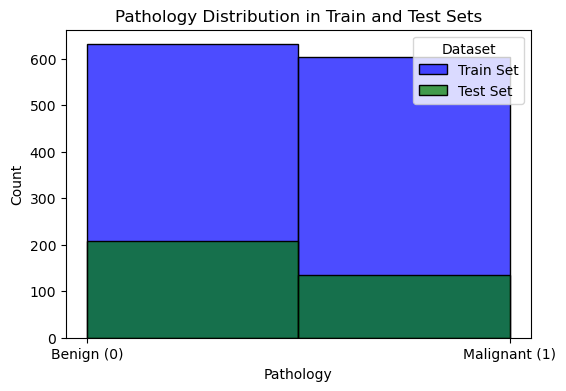

In [22]:
plt.figure(figsize=(6, 4))

# Plot for train set
sns.histplot(train_df['pathology'], bins=2, color='blue', kde=False, label='Train Set', alpha=0.7)

# Plot for test set
sns.histplot(test_df['pathology'], bins=2, color='green', kde=False, label='Test Set', alpha=0.7)

# Adding title and labels
plt.title('Pathology Distribution in Train and Test Sets', fontsize=12)
plt.xlabel('Pathology', fontsize=10)
plt.ylabel('Count', fontsize=10)

plt.xticks(ticks=[0, 1], labels=['Benign (0)', 'Malignant (1)'])

# Adding a legend
plt.legend(title='Dataset')

plt.show()

In [23]:
for col in categorical:
    df_group = train_df.groupby(col, observed=False).pathology.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_pathology_train
    df_group['risk'] = df_group['mean']/global_pathology_train
    display(df_group.sort_values(by='risk', ascending=False))
    print()

,mean,count,diff,risk
left_or_right_breast,,,,
LEFT,0.522538,599,0.033469,1.068434
RIGHT,0.457547,636,-0.031522,0.935548


,mean,count,diff,risk
image_view,,,,
CC,0.492147,573,0.003078,1.006293
MLO,0.486405,662,-0.002664,0.994553


,mean,count,diff,risk
mass_shape,,,,
IRREGULAR-ARCHITECTURAL_DISTORTION,0.941176,34,0.452108,1.924425
IRREGULAR,0.821958,337,0.332890,1.680660
ARCHITECTURAL_DISTORTION,0.650000,80,0.160931,1.329056
ASYMMETRIC_BREAST_TISSUE,0.400000,20,-0.089069,0.817881
LOBULATED,0.338983,295,-0.150086,0.693119
ROUND,0.333333,117,-0.155735,0.681567
OVAL,0.291667,312,-0.197402,0.596371
FOCAL_ASYMMETRIC_DENSITY,0.277778,18,-0.211291,0.567973
LYMPH_NODE,0.000000,22,-0.489069,0.000000


,mean,count,diff,risk
mass_margins,,,,
ILL_DEFINED-SPICULATED,0.884615,26,0.395547,1.808775
SPICULATED,0.879599,299,0.390530,1.798517
MICROLOBULATED,0.628319,113,0.139250,1.284724
ILL_DEFINED,0.623239,284,0.134171,1.274339
CIRCUMSCRIBED-ILL_DEFINED,0.481481,27,-0.007587,0.984486
OBSCURED,0.124378,201,-0.364691,0.254316
CIRCUMSCRIBED,0.112281,285,-0.376788,0.229581


In [24]:
from sklearn.metrics import mutual_info_score

def mutual_info_pathology_score(series):
    return mutual_info_score(series, train_df.pathology)

mi = train_df[categorical].apply(mutual_info_pathology_score)
mi = mi.sort_values(ascending=False).to_frame(name = 'MI')

display(mi)

,MI
mass_margins,0.226317
mass_shape,0.131722
left_or_right_breast,0.002112
image_view,0.000016


In [25]:
train_df = train_df.drop(columns=['image_view'], errors='ignore')
test_df = test_df.drop(columns=['image_view'], errors='ignore')
train_df.head() 

,breast_density,left_or_right_breast,abnormality_id,mass_shape,mass_margins,assessment,pathology,subtlety
0,3,LEFT,1,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,1,4
1,3,LEFT,1,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,1,4
2,3,LEFT,1,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,0,3
3,3,LEFT,1,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,0,3
4,3,RIGHT,1,OVAL,CIRCUMSCRIBED,4,0,5


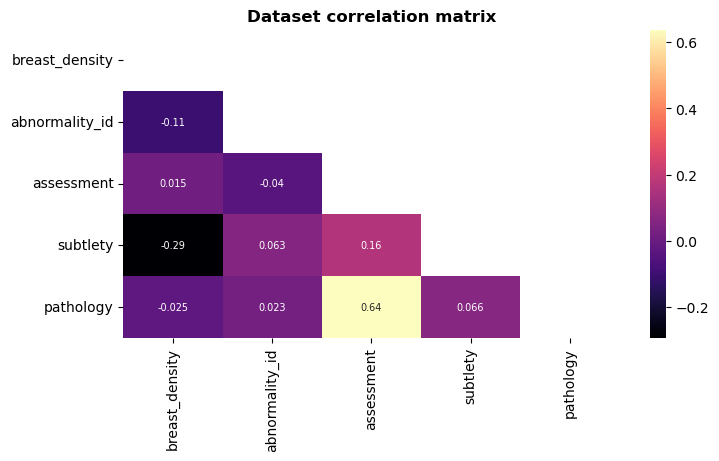

In [26]:
corr = train_df[numerical+['pathology']].corr(method = 'spearman')
plt.figure(figsize=(8, 4))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap = "magma", annot = True, annot_kws = {'size': 7})
plt.title("Dataset correlation matrix", fontsize = 12, fontweight = "bold")
plt.show()

In [27]:
scaler = MinMaxScaler()

train_df[numerical] = scaler.fit_transform(train_df[numerical])
test_df[numerical] = scaler.transform(test_df[numerical])

train_df['abnormality_id'].value_counts()

abnormality_id
0.0    1147
0.5      66
1.0      22
Name: count, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train_df, test_size = 0.2, random_state=1)


y_train = df_train['pathology']
y_val = df_val['pathology']
y_test = test_df['pathology']

del df_train['pathology']
del df_val['pathology']
del test_df['pathology']

In [29]:
# one hot encoding
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = test_df.to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [30]:
scoring = 'accuracy'

# Define models to train
models= []
models.append(('LR', LogisticRegression()))
models.append(('RandF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC())) 
models.append(('XGBoost',XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s Model:Mean accuracy is %f (Std accuracy is %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR Model:Mean accuracy is 0.824974 (Std accuracy is 0.035288)
RandF Model:Mean accuracy is 0.886642 (Std accuracy is 0.025460)
CART Model:Mean accuracy is 0.877530 (Std accuracy is 0.021437)
SVM Model:Mean accuracy is 0.831004 (Std accuracy is 0.034571)
XGBoost Model:Mean accuracy is 0.898825 (Std accuracy is 0.024618)
KNN Model:Mean accuracy is 0.829015 (Std accuracy is 0.033965)


In [52]:
# Make predictions on validation dataset

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    print("\nModel:",name)
    print("Accuracy score:",accuracy_score(y_val, predictions))
    print("Classification report:\n",classification_report(y_val, predictions))


Model: LR
Accuracy score: 0.8178137651821862
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       126
           1       0.82      0.80      0.81       121

    accuracy                           0.82       247
   macro avg       0.82      0.82      0.82       247
weighted avg       0.82      0.82      0.82       247


Model: RandF
Accuracy score: 0.8461538461538461
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       126
           1       0.88      0.79      0.83       121

    accuracy                           0.85       247
   macro avg       0.85      0.85      0.85       247
weighted avg       0.85      0.85      0.85       247


Model: CART
Accuracy score: 0.8137651821862348
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       126
           1       0.8

### Selected Moddel: RandomForest

In [53]:
# Set the parameters dictionary
parameters = {
    "n_estimators": [10, 50, 100, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3],
    "min_samples_split": [2, 3],
    "min_samples_leaf": [1, 2],
}

# Instantiate the model and classifier
random_forest = RandomForestClassifier()
clf_rf = GridSearchCV(random_forest, parameters)

# Fit
clf_rf.fit(X_train, y_train)
clf_rf.best_estimator_
clf_rf.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 50}

In [54]:
random_forest_best = RandomForestClassifier(
    n_estimators=50,
    criterion="gini",
    max_depth=3,
    min_samples_split=3,
    min_samples_leaf=2,
)
random_forest_best.fit(X_train, y_train)

predicted_val_rf = random_forest_best.predict(X_val)
predicted_test_rf = random_forest_best.predict(X_test)

print('Accuracy', clf_rf.best_score_)
print('Validation roc_auc_score', roc_auc_score(y_val, predicted_val_rf))
print('Test roc_auc_score', roc_auc_score(y_test, predicted_test_rf))

Accuracy 0.8370712198123366
Validation roc_auc_score 0.7994883903974813
Test roc_auc_score 0.7811718917374848


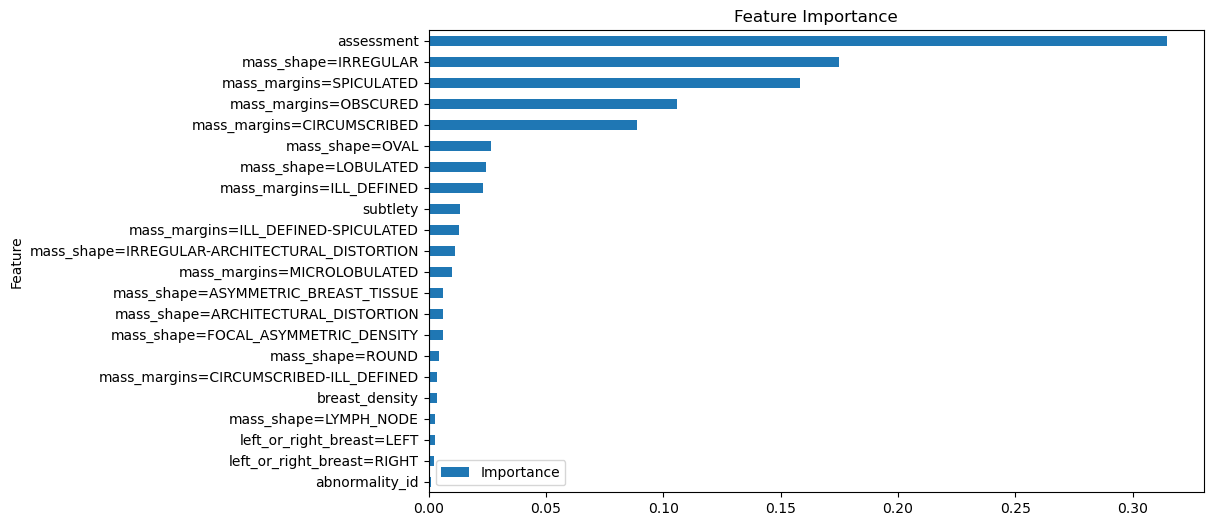

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

feature_names = dv.get_feature_names_out()

feature_importance = pd.DataFrame(
    {"Feature":  feature_names, "Importance": random_forest_best.feature_importances_}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

              precision    recall  f1-score   support

           0       0.87      0.70      0.78       209
           1       0.64      0.84      0.73       134

    accuracy                           0.76       343
   macro avg       0.76      0.77      0.75       343
weighted avg       0.78      0.76      0.76       343



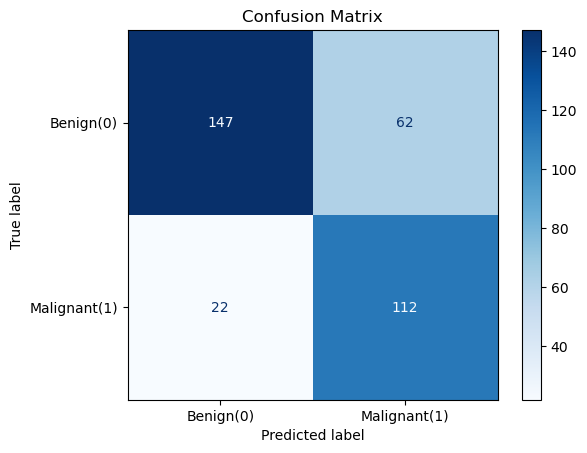

In [56]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_test, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, predicted_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['Benign(0)', 'Malignant(1)'])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()